# Quick start

## Introduction

In this quick start you will calculate the temperature progression of a power transformer exposed to a constant load during a summer week.

Before we start modelling the transformer, we will first import all the required functions and classes.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
from transformer_thermal_model.schemas import InputProfile, UserTransformerSpecifications
from transformer_thermal_model.transformer import PowerTransformer

## Create input data

First we will create data to simulate the ambient temperature during this summer week together with a constant load.

Both profiles will have a duration of a week with a sampling time of 15 minutes. 

_Note that other sampling times can be used, but preferably 15 minutes or lower._

In [2]:
one_week = 4 * 24 * 7
datetime_index = pd.date_range("2025-07-01", periods=one_week, freq="15min")

# The ambient temperature during this week is 20 degrees celsius
ambient_temp = 20
ambient_series = pd.Series([ambient_temp] * one_week, index=datetime_index)

# And the transformer is exposed to a nominal load of 100 Ampere:
load = 100
load_series = pd.Series([load] * one_week, index=datetime_index)

# Create an input object with the profiles
my_profile_input = InputProfile.create(
    datetime_index=datetime_index, load_profile=load_series, ambient_temperature_profile=ambient_series
)

## A transformer object

The next step is to create a power transformer object. We will use the default specifications of the power transformer. Additionally, there are five mandatory specifications to be set: 
* The nominal current at the secondary side [A]
* The load loss [W]
* The no-load loss [W]
* The ambient temperature surcharge [K]
* The cooling type (ONAN or ONAF)

The first four specifications are set using the `UserTransformerSpecifications` object and the cooler type is selected using the CoolerType enumerator.
_Note that the values are chosen randomly._

In [3]:
my_transformer_specifications = UserTransformerSpecifications(
    load_loss=1000,  # Transformer load loss [W]
    nom_load_sec_side=1500,  # Transformer nominal current secondary side [A]
    no_load_loss=200,  # Transformer no-load loss [W]
    amb_temp_surcharge=20,  # Ambient temperature surcharge [K]
)
my_cooler_type = CoolerType.ONAN
my_transformer = PowerTransformer(user_specs=my_transformer_specifications, cooling_type=my_cooler_type)

The default specifications of a power transformer can be consulted with the `default` property:

In [4]:
my_transformer.defaults

DefaultTransformerSpecifications(time_const_oil=210.0, time_const_windings=10.0, top_oil_temp_rise=60.0, winding_oil_gradient=17.0, hot_spot_fac=1.3, oil_const_k11=0.5, winding_const_k21=2, winding_const_k22=2, oil_exp_x=0.8, winding_exp_y=1.3, end_temp_reduction=0.0)

The specifications that are used in the thermal model can be consulted in the `specs` property.
Note that the `defaults` and the `specs` can differ and the specification that are used in the model are `my_transformer.specs`.

In [5]:
my_transformer.specs

TransformerSpecifications(load_loss=1000.0, nom_load_sec_side=1500.0, no_load_loss=200.0, amb_temp_surcharge=20.0, time_const_oil=210.0, time_const_windings=10.0, top_oil_temp_rise=60.0, winding_oil_gradient=17.0, hot_spot_fac=1.3, oil_const_k11=0.5, winding_const_k21=2, winding_const_k22=2, oil_exp_x=0.8, winding_exp_y=1.3, end_temp_reduction=0.0)

## Running the thermal model

Now it is time to create a `my_model` object from the `Model` class. This object is initiated with the my_transformer and the my_profiles object. Then we run the model to create a temperature profile of the top-oil and the hot-spot.

In [6]:
my_model = Model(temperature_profile=my_profile_input, transformer=my_transformer)

results = my_model.run()

The output, `results`, contains to output profiles: the top-oil temperature profile and the hot-spot temperature profile. 


Because we did not define an initial temperature, the model sets the initial temperature to the ambient plus the temperature surcharge. In reality, the transformer might have been warmer than ambient temperature due e.g. to previous loads. To compensate this, a warm-up period should be cut off. Typically a period of 5 times the oil time constant in minutes is used: `my_transformer.specs.time_const_oil * 5`.  In this period the transformer had enough time to warm up or cool down to match the applied load and ambient temperature



In [7]:
start_time = datetime_index[0] + pd.Timedelta(my_transformer.specs.time_const_oil * 5, "m")

Now we calculated the correct starting-time, we use this to plot the top-oil and hotspot temperature to see how warm our transformer is under this constant load.

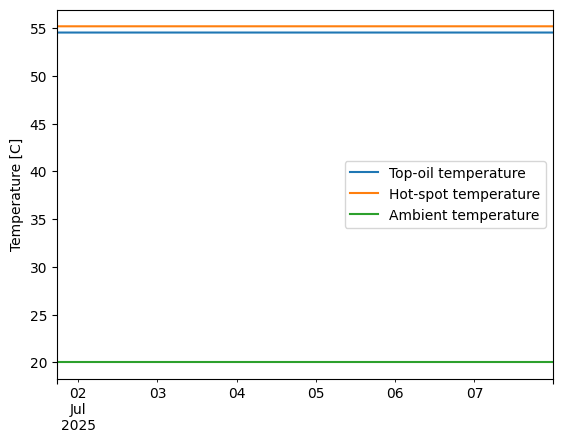

In [8]:
fig = plt.figure()
ax = results.top_oil_temp_profile.loc[start_time::].plot(label="Top-oil temperature")
results.hot_spot_temp_profile.loc[start_time::].plot(label="Hot-spot temperature")
ambient_series.loc[start_time::].plot(label="Ambient temperature")
ax.set_ylabel("Temperature [C]")

ax.legend();

## Summary

In this quick start the basic principles of the Transformer Thermal Model are shown.
You learned to model the top-oil and hot-spot temperature based on an `InputProfile` instance and a `Transformer` instance. 

For more detailed information and modelling with dynamic profiles you can go through the other examples.